In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os 
import numpy as np

from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr
import ccxt
import warnings
import seaborn as sns

#auto reload modules
%load_ext autoreload

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
path_perfomers_5min = r'c:\Users\tariq\algorithmic_trading\5min_perp'
path_perfomers_1min = r'c:\Users\tariq\algorithmic_trading\1min_perp'
path_perfomers_3min = r'c:\Users\tariq\algorithmic_trading\3min_perp'
path_perfomers_7min = r'c:\Users\tariq\algorithmic_trading\7min_perp'
path_perfomers_10min = r'c:\Users\tariq\algorithmic_trading\10min_perp'
path_perfomers_15min = r'c:\Users\tariq\algorithmic_trading\15min_perp'

### Backtest strategie

achat lors d'une baisse > 5% sur une bougie de 5 min et revente après 5 min.

In [45]:
def plot_extreme_candle_strat(trades_df, pair_name, buy_hold=True):
    plt.figure(figsize=(18, 8))
    
    plt.plot(trades_df["timestamp"], trades_df["cumulative_return"], label="Stratégie", color="blue")
    plt.scatter(trades_df["timestamp"], trades_df["cumulative_return"], color="orange", label="Trades", s=5, zorder=5)

    if buy_hold:
        plt.plot(trades_df["timestamp"], trades_df["buy_hold_ret"], label="Buy & Hold", color="red", linestyle="dashed")

    plt.xlabel("Date")
    plt.ylabel("Performance cumulée")
    plt.title(f"Évolution des rendements - {pair_name}")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


### Ethereum plot

nombre total de trade 2586
return final -0.36042572691741326
-0.2772388406423468
ret moyen par trade  -6.92761197410469e-05 median  0.00014397292281319806


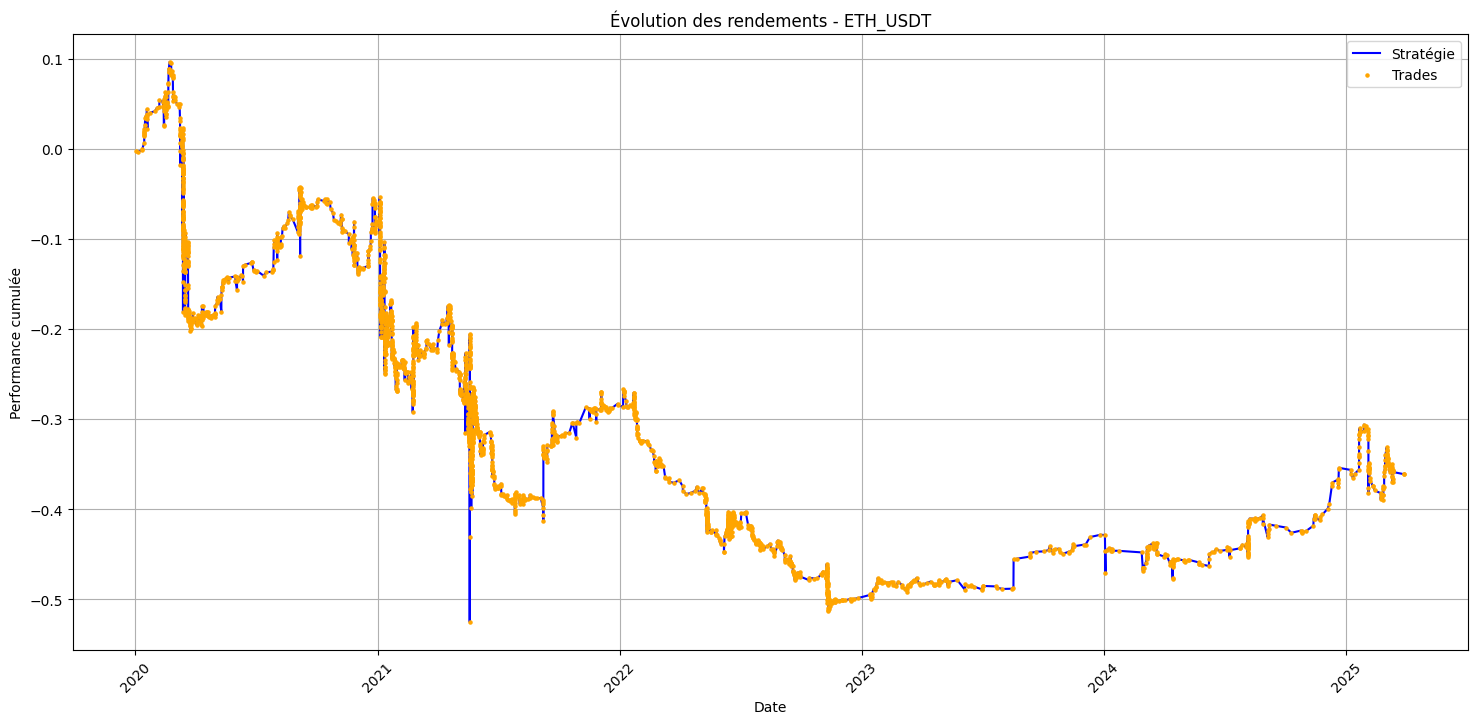

In [47]:
# import sys
# sys.path.append(r'c:\Users\tariq\algorithmic_trading')
# from extreme_candle_strat import backtest_extreme_candle_pair_vectorized

def backtest_extreme_candle_pair_vectorized(filepath, threshold=-0.05):
    df = pd.read_parquet(filepath)
    df["date"] = pd.to_datetime(df["date"])
    
    df["ret"] = np.log(df["close"] / df["close"].shift(1))
    df["logreturn_1"] = df["ret"].shift(1) 
    df["buy_hold_ret"] = (1 + df["ret"]).cumprod() - 1

    # signaux
    signal_mask = df["ret"] < threshold

    # Shift pour avoir accès aux données futures
    df["open_next"] = df["open"].shift(-1)
    df["close_after"] = df["close"].shift(-1)
    # df["close_plus_2"] = df["close"].shift(-2)

    # Calcul du return du trade
    # df["return"] = np.log(df["close_after"] / df["open_next"]) - 0.0001
    df["return"] =(df["close_after"] - df["open_next"]) / (df["open_next"]) - 0.001
    # df["trade_return"] = np.log(df["close_plus_2"] / df["close_after"]) - 0.0001  # alternative

    # Ne garder que les lignes avec signal
    trades = df[signal_mask].copy()
    trades["pair"] = filepath.split("_")[0]
    trades["timestamp"] = trades["date"]

    trades = trades[["pair", "timestamp", "open_next", "close_after", "return", "buy_hold_ret"]]

    if not trades.empty:
        trades["cumulative_return"] = (1 + trades["return"]).cumprod() - 1
    else:
        print(f"Aucun trade détecté pour {filepath}")

    return trades


eth_trades = backtest_extreme_candle_pair_vectorized(os.path.join(path_perfomers_5min, "ETH_USDT_USDT.parquet"), threshold=-0.01)
eth_trades["date"] = eth_trades["timestamp"].dt.date    
# print("nombre total de trades", len(eth_trades))
print("nombre total de trade", len(eth_trades)) ; print("return final", eth_trades["cumulative_return"].iloc[-1]) ; max_portfolio_loss = np.min(eth_trades["cumulative_return"]) ; max_trade_loss = np.min(eth_trades["return"])
print(max_trade_loss)
print("ret moyen par trade ", eth_trades["return"].mean(), "median ", eth_trades["return"].median())
plot_extreme_candle_strat(eth_trades, "ETH_USDT", buy_hold=False)

nombre total de trade 2813
return final -0.2588629083886832
-0.09566829778015645
ret moyen par trade  -1.0319158158524465e-05 median  0.00015126752296889525


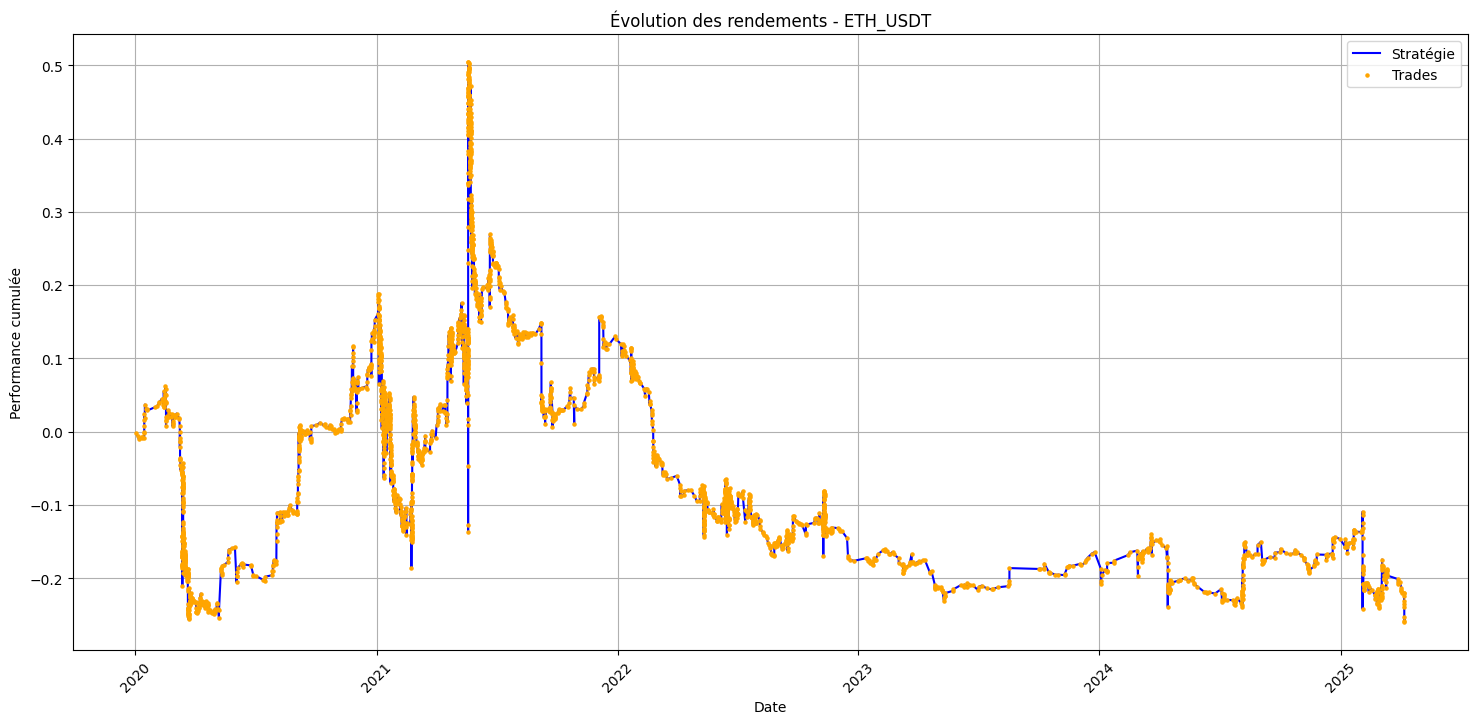

In [48]:
eth_trades = backtest_extreme_candle_pair_vectorized(os.path.join(path_perfomers_7min, "ETH_USDT_USDT.parquet"), threshold=-0.01)
eth_trades["date"] = eth_trades["timestamp"].dt.date    
# print("nombre total de trades", len(eth_trades))
print("nombre total de trade", len(eth_trades)) ; print("return final", eth_trades["cumulative_return"].iloc[-1]) ; max_portfolio_loss = np.min(eth_trades["cumulative_return"]) ; max_trade_loss = np.min(eth_trades["return"])
print(max_trade_loss)
print("ret moyen par trade ", eth_trades["return"].mean(), "median ", eth_trades["return"].median())
plot_extreme_candle_strat(eth_trades, "ETH_USDT", buy_hold=False)

In [49]:
def compute_sharpe_ratio(trades) : 
    returns = trades["return"] 
    excess_returns = returns 
    sharpe_ratio = excess_returns.mean() / excess_returns.std() 
    return sharpe_ratio

In [50]:
def compute_metrices(thresold, trades):
    trades = trades.iloc[1:].dropna(subset=["cumulative_return", "return"])
    
    sharpe_ratio = compute_sharpe_ratio(trades)
    nb_trades = len(trades)
    max_portfolio_loss = np.min(trades["cumulative_return"])
    max_trade_loss = np.min(trades["return"])
    mean_return = trades["return"].mean()
    median_return = trades["return"].median()

    nb_winning_trades = len(trades[trades["return"] > 0])
    nb_losing_trades = len(trades[trades["return"] < 0])

    percentage_winning_trades = (nb_winning_trades / nb_trades) * 100 
    average_winning_trade_ret = trades[trades["return"] > 0]["return"].mean()
    average_losing_trade_ret = trades[trades["return"] < 0]["return"].mean()

    final_return = trades["cumulative_return"].iloc[-1]
    #vol of cumulative return
    vol_cumulative_return = trades["cumulative_return"].std()
    #vol of return
    vol_return = trades["return"].std()
    # Linearity study
    trades['timestamp_numeric'] = (trades['timestamp'] - trades['timestamp'].min()).dt.total_seconds().dropna()
    X = trades['timestamp_numeric'].values.reshape(-1, 1)
    y = trades['cumulative_return'].values
    #dropna

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r_squared = model.score(X, y)

    #correlation between strategy and buy and hold with pearsonr
    corr = pearsonr(trades["cumulative_return"], trades["buy_hold_ret"])
    #dataframe with these values
    metrics_df = pd.DataFrame({
        "threshold": [thresold],
        "sharpe_ratio": [sharpe_ratio],
        "final_return": [final_return],
        "nb_trades": [nb_trades],
        "max_portfolio_loss": [max_portfolio_loss],
        "max_trade_loss": [max_trade_loss],
        "mean_return": [mean_return],
        "median_return": [median_return],
        "nb_winning_trades": [nb_winning_trades],
        "nb_losing_trades": [nb_losing_trades],
        "percentage_winning_trades": [percentage_winning_trades],
        "average_winning_trade_ret": [average_winning_trade_ret],
        "average_losing_trade_ret": [average_losing_trade_ret],
        "vol_cumulative_return": [vol_cumulative_return],
        "vol_return": [vol_return],
        "r_squared": [r_squared],
        "corr": [corr[0]],
    })
    return metrics_df


In [51]:
def perform_backtest(path, thresolds, filename="ETH_USDT_USDT.parquet"):
    """
    Effectue un backtest pour un ensemble de seuils donné et un chemin spécifique.

    Args:
        path (str): Chemin vers le dossier contenant les fichiers de données.
        thresolds (array-like): Liste ou tableau de seuils à tester.
        filename (str): Nom du fichier à utiliser pour le backtest.

    Returns:
        pd.DataFrame: Résultats du backtest sous forme de DataFrame.
    """
    backtest_results = []
    for thresold in thresolds:
        trades = backtest_extreme_candle_pair_vectorized(os.path.join(path, filename), threshold=thresold)
        if trades.empty:
            continue
        metrics_df = compute_metrices(thresold, trades)
        backtest_results.append(metrics_df)
    return pd.concat(backtest_results, ignore_index=True) if backtest_results else pd.DataFrame()

In [52]:
paths = {
    "5min": r'c:\Users\tariq\algorithmic_trading\5min_perp',
    "6min"  : r'c:\Users\tariq\algorithmic_trading\6min_perp',
    # "1min": r'c:\Users\tariq\algorithmic_trading\1min_perp',
    # "3min": r'c:\Users\tariq\algorithmic_trading\3min_perp',
    "7min": r'c:\Users\tariq\algorithmic_trading\7min_perp',
    "10min": r'c:\Users\tariq\algorithmic_trading\10min_perp',
    "15min": r'c:\Users\tariq\algorithmic_trading\15min_perp',
}

thresolds = np.linspace(-0.0001, -0.04, 200)
backtest_results = {}
for interval, path in paths.items():
    print(f"Running backtest for {interval} candles...")
    backtest_results[f"{interval}_df"] = perform_backtest(path, thresolds)

backtest_results_df_5_min = backtest_results["5min_df"]
backtest_results_df_6_min = backtest_results["6min_df"]
backtest_results_df_7_min = backtest_results["7min_df"]
backtest_results_df_10_min = backtest_results["10min_df"]
# backtest_results_df_15_min = backtest_results["15min_df"]

Running backtest for 5min candles...
Running backtest for 6min candles...
Running backtest for 7min candles...
Running backtest for 10min candles...
Running backtest for 15min candles...


### Backtest comparison

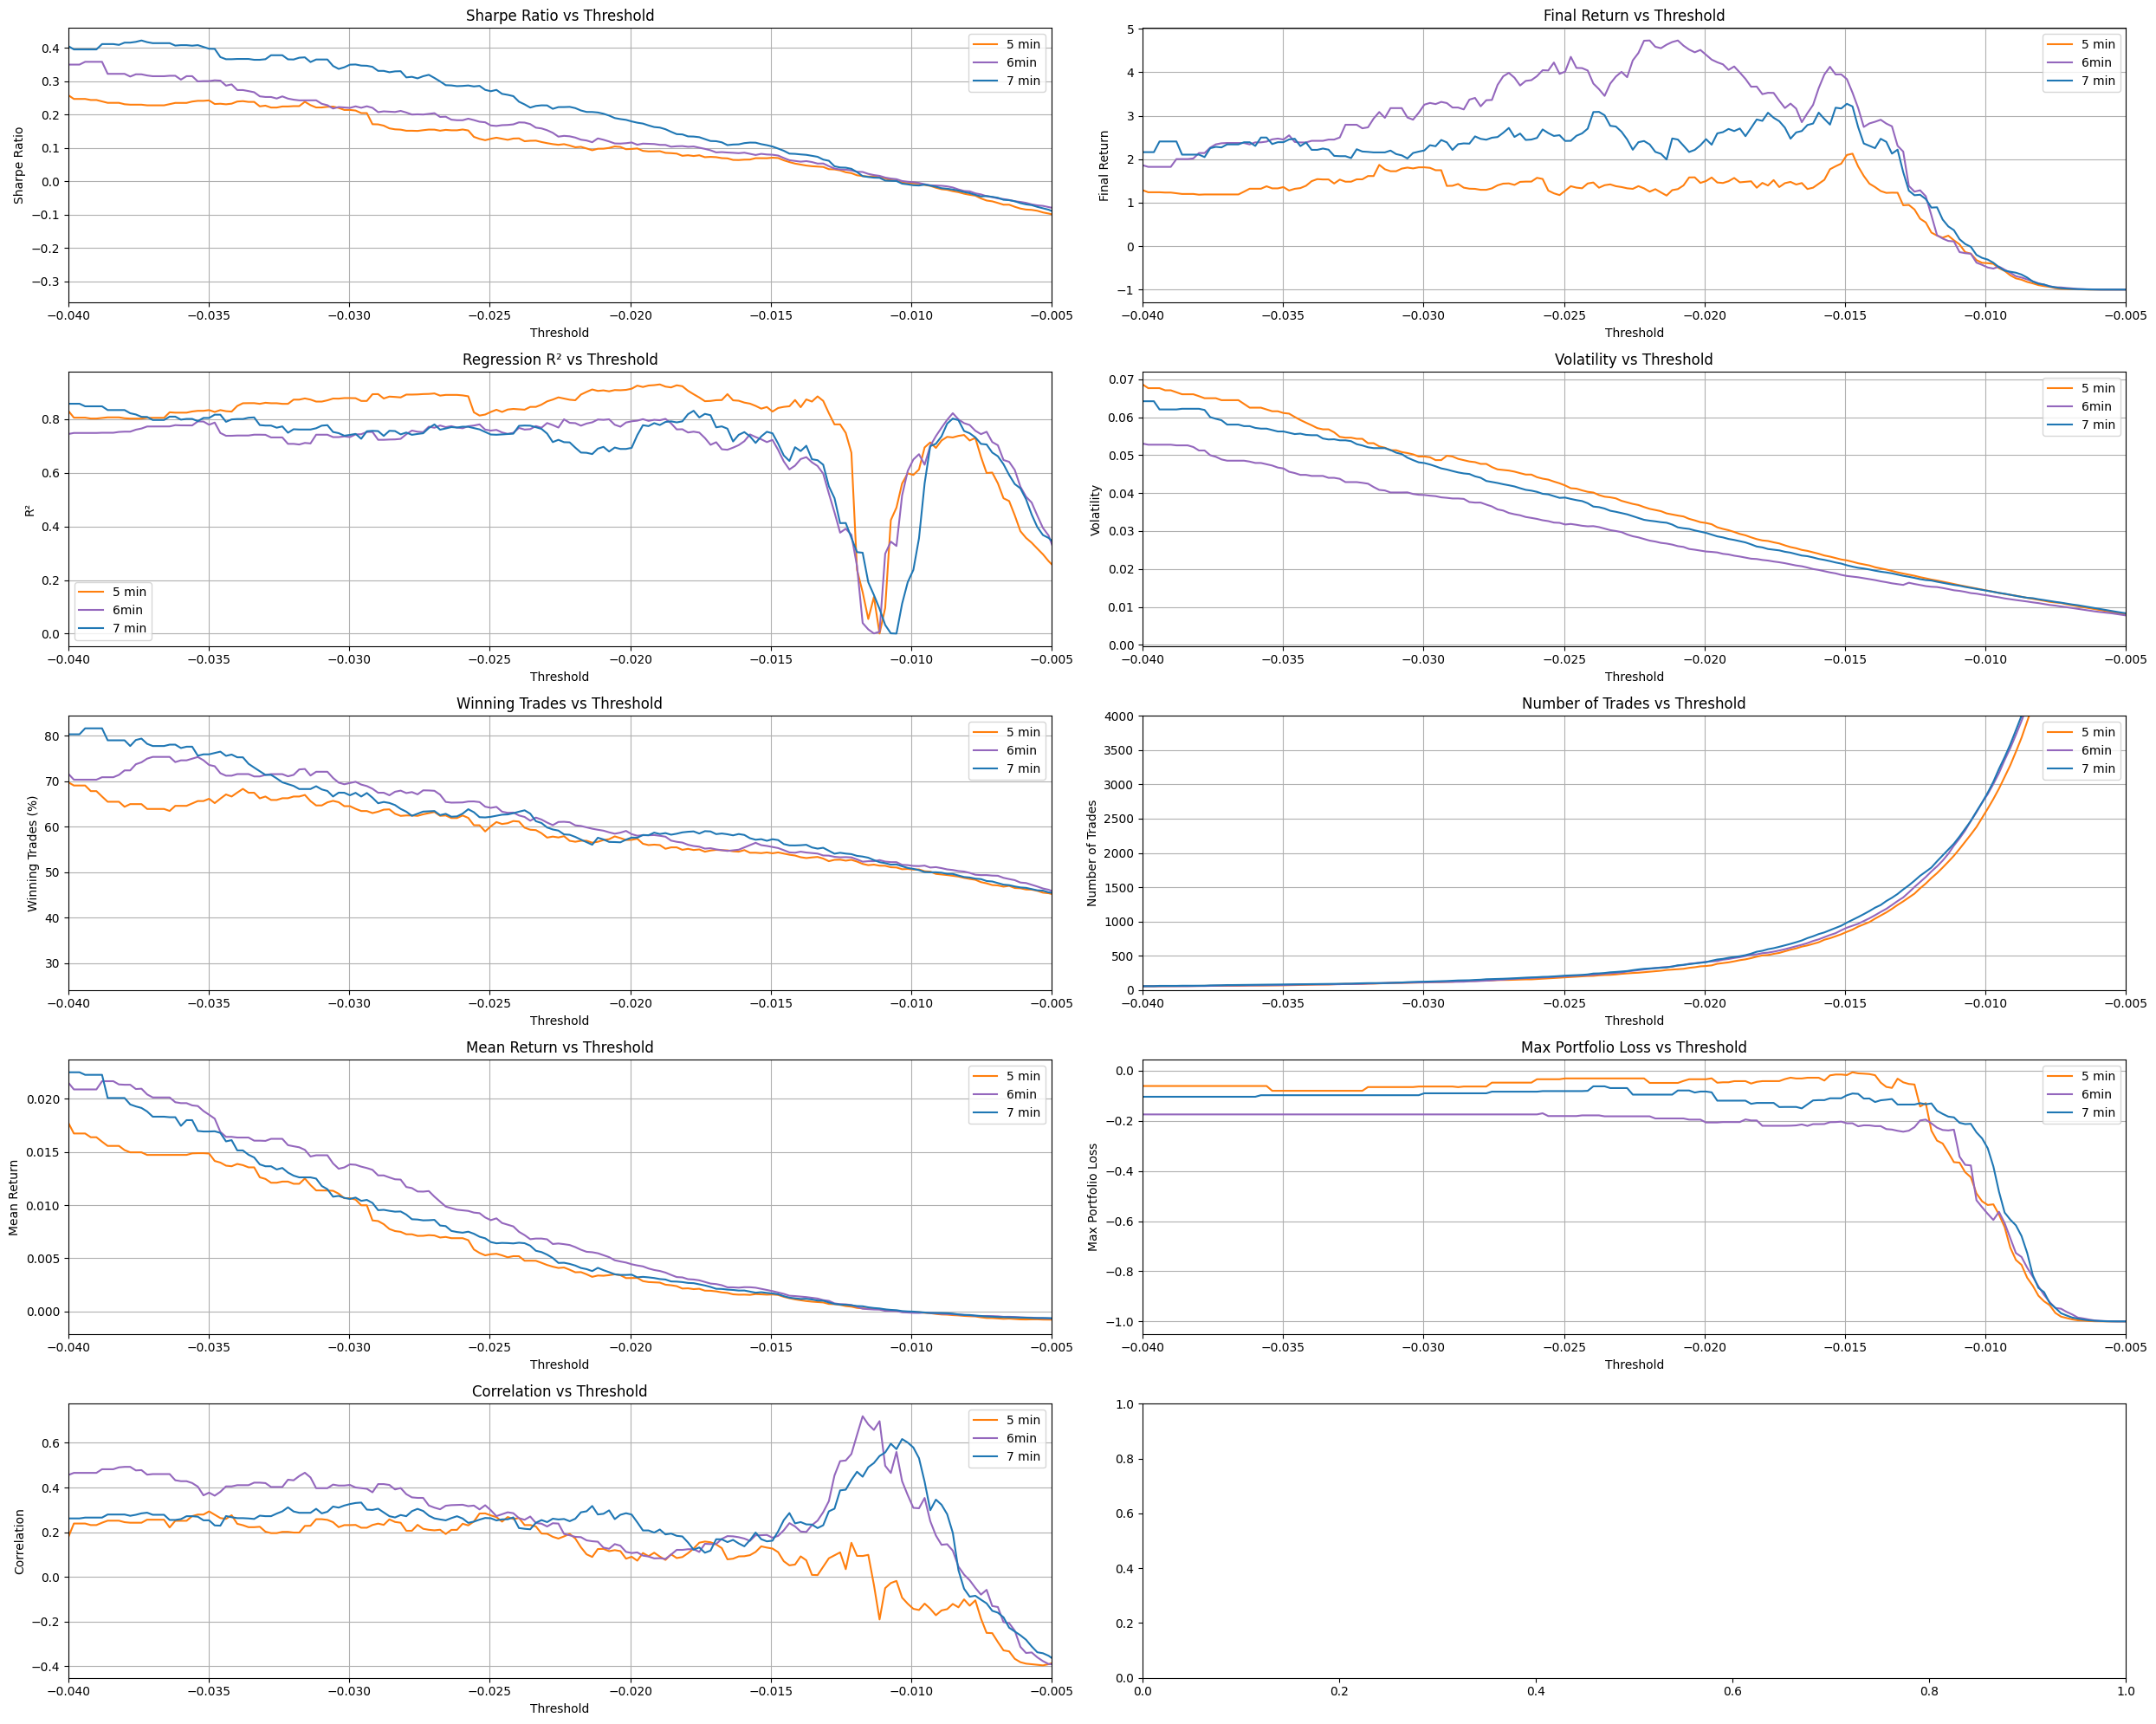

In [ ]:
import matplotlib.pyplot as plt
def initialize_figure(rows, cols, figsize=(25, 20)):
    """
    Initialise une figure avec des subplots.
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  
    return fig, axes

# Fonction pour ajouter plusieurs courbes sur un même plot
def add_plot(ax, x_data, y_data, xlabel, ylabel, title, labels, colors, grid=True, xlim=None, ylim=None):
    """
    Ajoute plusieurs graphiques à un axe donné.
    """
    for x, y, label, color in zip(x_data, y_data, labels, colors):
        ax.plot(x, y, label=label, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    if grid:
        ax.grid(True)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

# Couleurs cohérentes pour chaque type de bougie
colors = {
    "5min": "tab:orange",
    "6min" : "tab:purple",
    "7min": "tab:blue",
    "10min": "tab:green",
    "15min": "tab:red"
}

labels = ["5 min", "6min", "7 min", "10 min", "15 min"]
thresholds = [
    backtest_results_df_5_min["threshold"],
    backtest_results_df_6_min["threshold"],
    backtest_results_df_7_min["threshold"],
    # backtest_results_df_10_min["threshold"],
    # backtest_results_df_6_min["threshold"]
]

fig, axes = initialize_figure(5, 2)
# Sharpe Ratio vs Threshold
add_plot(
    axes[0],
    thresholds,
    [
        backtest_results_df_5_min["sharpe_ratio"],
        backtest_results_df_7_min["sharpe_ratio"],
        backtest_results_df_6_min["sharpe_ratio"]
        # backtest_results_df_10_min["sharpe_ratio"],
        # backtest_results_df_6_min["sharpe_ratio"]
    ],
    xlabel="Threshold", ylabel="Sharpe Ratio", title="Sharpe Ratio vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# Final Return vs Threshold
add_plot(
    axes[1],
    thresholds,
    [
        backtest_results_df_5_min["final_return"],
        backtest_results_df_6_min["final_return"],
        backtest_results_df_7_min["final_return"],
        # backtest_results_df_10_min["final_return"],
        # backtest_results_df_6_min["final_return"]
    ],
    xlabel="Threshold", ylabel="Final Return", title="Final Return vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# R² vs Threshold
add_plot(
    axes[2],
    thresholds,
    [
        backtest_results_df_5_min["r_squared"],
        backtest_results_df_6_min["r_squared"],
        backtest_results_df_7_min["r_squared"],
        # backtest_results_df_10_min["r_squared"],
        # backtest_results_df_6_min["r_squared"]
    ],
    xlabel="Threshold", ylabel="R²", title="Regression R² vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# Volatility vs Threshold
add_plot(
    axes[3],
    thresholds,
    [
        backtest_results_df_5_min["vol_return"],
        backtest_results_df_6_min["vol_return"],
        backtest_results_df_7_min["vol_return"],
        # backtest_results_df_10_min["vol_return"],
        # backtest_results_df_6_min["vol_return"]
    ],
    xlabel="Threshold", ylabel="Volatility", title="Volatility vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# Winning Trades (%) vs Threshold
add_plot(
    axes[4],
    thresholds,
    [
        backtest_results_df_5_min["percentage_winning_trades"],
        backtest_results_df_6_min["percentage_winning_trades"],
        backtest_results_df_7_min["percentage_winning_trades"],
        # backtest_results_df_10_min["percentage_winning_trades"],
        # backtest_results_df_6_min["percentage_winning_trades"]
    ],
    xlabel="Threshold", ylabel="Winning Trades (%)", title="Winning Trades vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# Number of Trades vs Threshold
add_plot(
    axes[5],
    thresholds,
    [
        backtest_results_df_5_min["nb_trades"],
        backtest_results_df_6_min["nb_trades"],
        backtest_results_df_7_min["nb_trades"],
        # backtest_results_df_10_min["nb_trades"],
        # backtest_results_df_6_min["nb_trades"]
    ],
    xlabel="Threshold", ylabel="Number of Trades", title="Number of Trades vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005), ylim=(0, 4000)
)

# Mean Return vs Threshold
add_plot(
    axes[6],
    thresholds,
    [
        backtest_results_df_5_min["mean_return"],
        backtest_results_df_6_min["mean_return"],
        backtest_results_df_7_min["mean_return"],
        # backtest_results_df_10_min["mean_return"],
        # backtest_results_df_6_min["mean_return"]
    ],
    xlabel="Threshold", ylabel="Mean Return", title="Mean Return vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# Max Portfolio Loss vs Threshold
add_plot(
    axes[7],
    thresholds,
    [
        backtest_results_df_5_min["max_portfolio_loss"],
        backtest_results_df_6_min["max_portfolio_loss"],
        backtest_results_df_7_min["max_portfolio_loss"],
        # backtest_results_df_10_min["max_portfolio_loss"],
        # backtest_results_df_6_min["max_portfolio_loss"]
    ],
    xlabel="Threshold", ylabel="Max Portfolio Loss", title="Max Portfolio Loss vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)

# Pearson Correlation vs Threshold
add_plot(
    axes[8],
    thresholds,
    [
        backtest_results_df_5_min["corr"],
        backtest_results_df_6_min["corr"],
        backtest_results_df_7_min["corr"],
        # backtest_results_df_10_min["corr"],
        # backtest_results_df_6_min["corr"]
    ],
    xlabel="Threshold", ylabel="Correlation", title="Correlation vs Threshold",
    labels=labels, colors=list(colors.values()), xlim=(-0.04, -0.005)
)
#okk
plt.tight_layout()
plt.show()

Now we can try incorporating momentum indicators like RSI or MACD to filter trades. For example, we can only buy when the RSI is below 30.

In [85]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [113]:
eth_5min_data = pd.read_parquet(os.path.join(path_perfomers_5min, "ETH_USDT_USDT.parquet"))
eth_trades = backtest_extreme_candle_pair_vectorized(os.path.join(path_perfomers_5min, "ETH_USDT_USDT.parquet"), threshold=-0.01)

# def add_rsi_to_trades(rsi=[ 4, 6, 8, 10,12, 14]):
eth_5min_data["date"] = pd.to_datetime(eth_5min_data["date"])
eth_trades["timestamp"] = pd.to_datetime(eth_trades["timestamp"])
eth_trades["rsi_timestamp"] = eth_trades["timestamp"] - pd.Timedelta(minutes=5)

rsi_s=[ 4, 6, 8, 10,12, 14]
for period in rsi_s:
    eth_5min_data[f"rsi_{period}"] = compute_rsi(eth_5min_data["close"], period=period)

# Merge the trades with the RSI data
eth_trades = eth_trades.merge(
    eth_5min_data[["date", "rsi_4", "rsi_6", "rsi_8", "rsi_10", "rsi_12", "rsi_14"]],
    left_on="rsi_timestamp",
    right_on="date",
    how="left"
)



In [116]:
# 1. Classer les retours en 10 quantiles
eth_trades["return_decile"] = pd.qcut(eth_trades["return"], q=100, labels=[f"D{i+1}" for i in range(100)])
# for each rsis
rsi_decile = {}
return_decile = {}
for rsi in rsi_s : 
    rsi_dec = eth_trades.groupby("return_decile")[f"rsi_{rsi}"].mean()
# rsi_by_decile = eth_trades.groupby("return_decile")["rsi_14"].mean()
    return_dec = eth_trades.groupby("return_decile")["return"].mean()
    rsi_decile[rsi] = rsi_dec
    return_decile[rsi] = return_dec

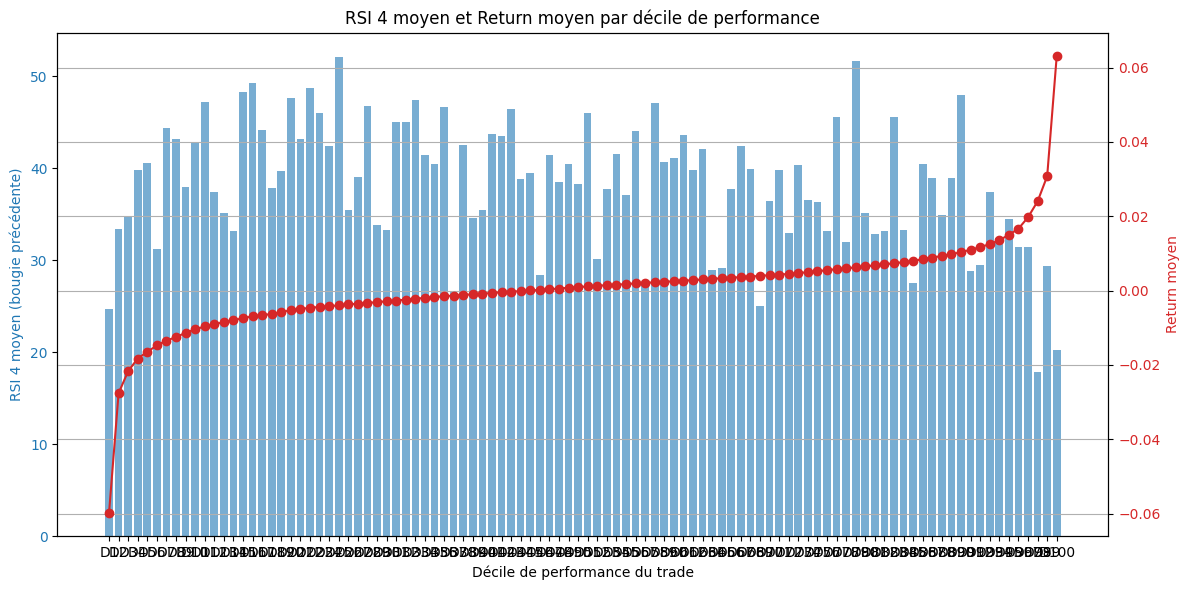

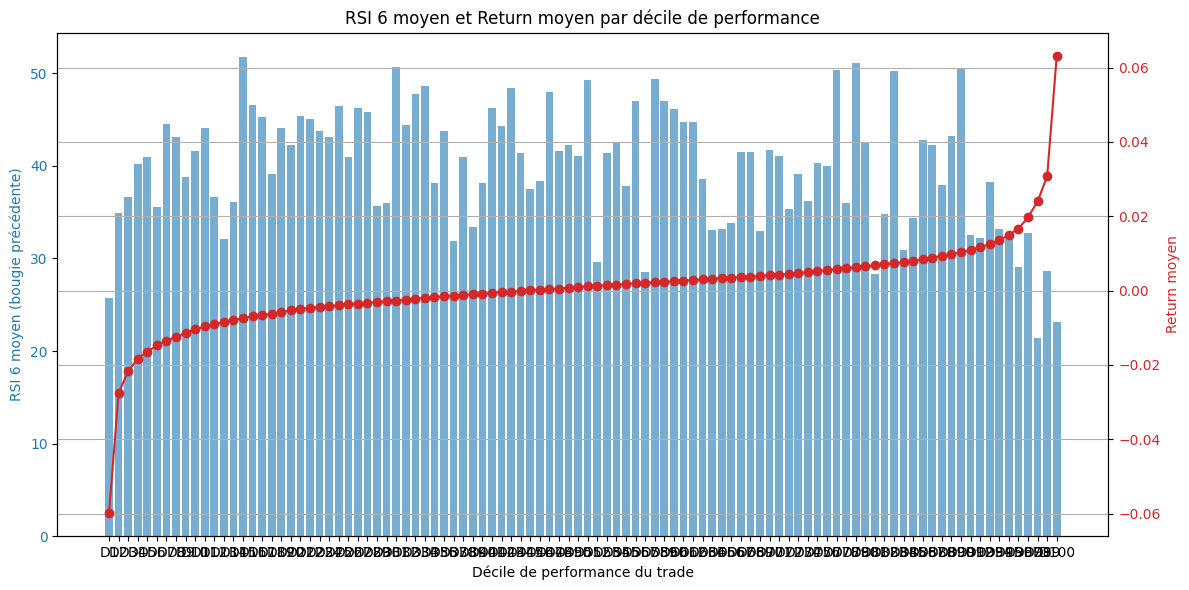

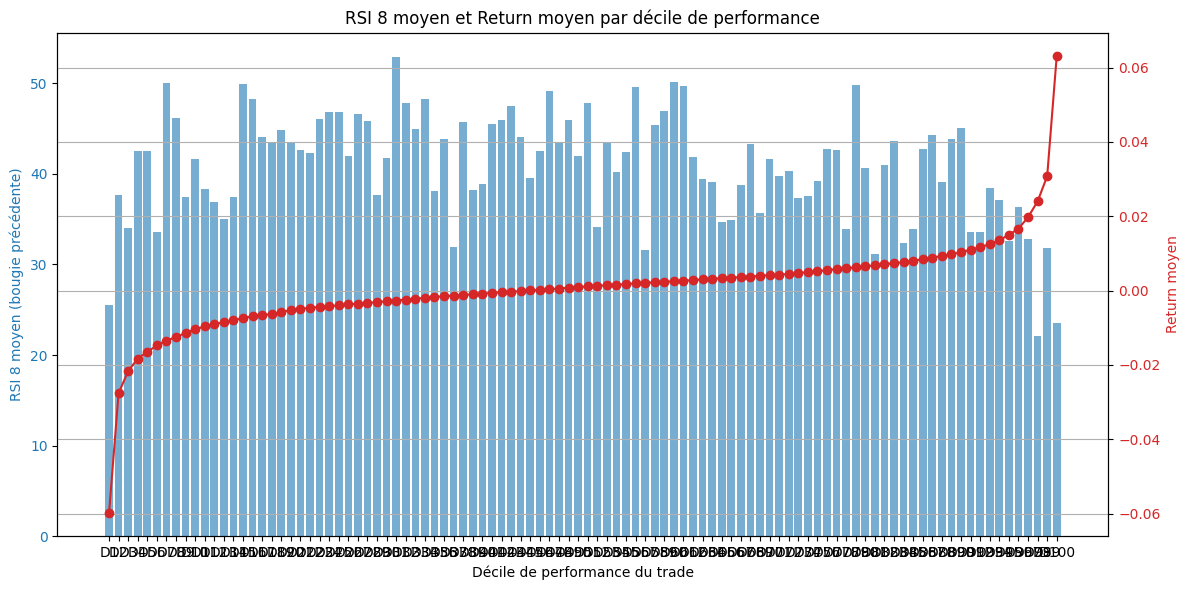

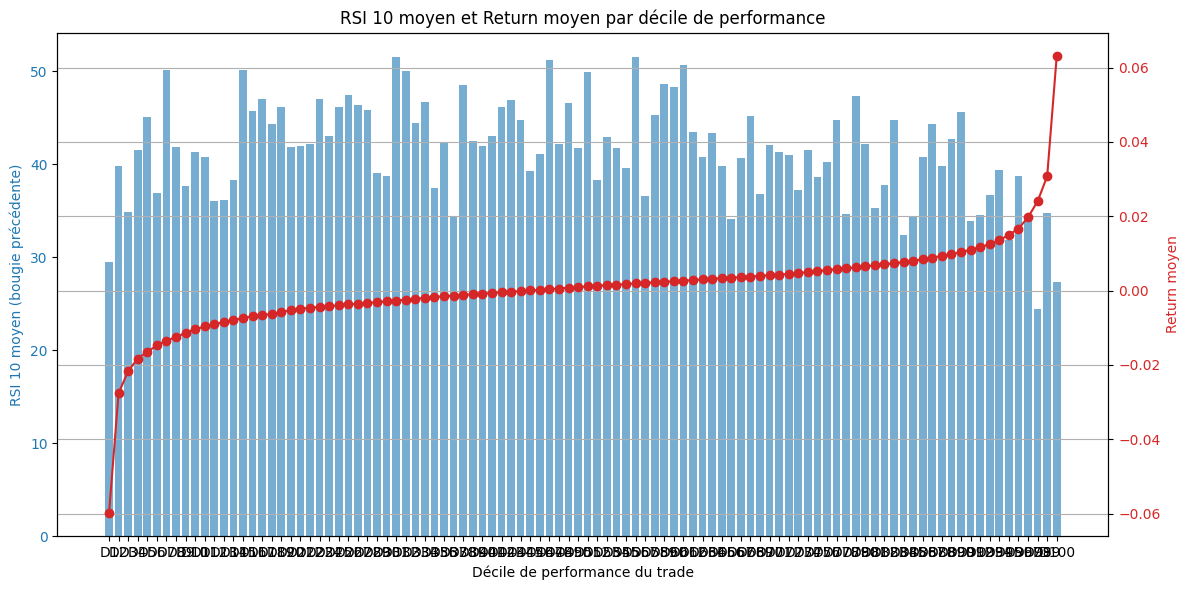

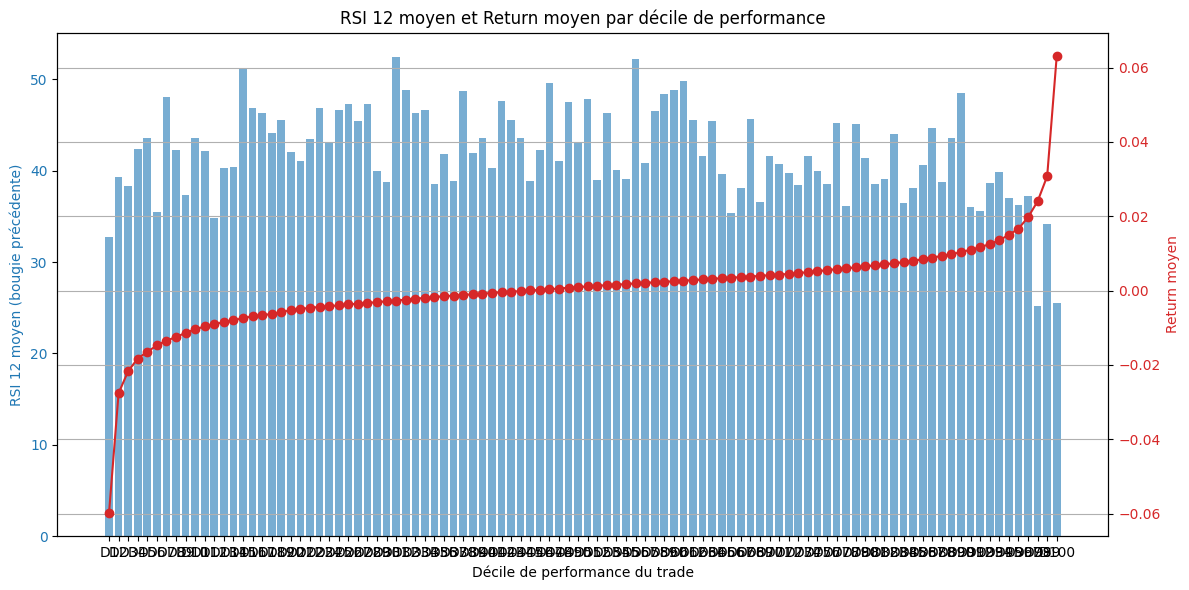

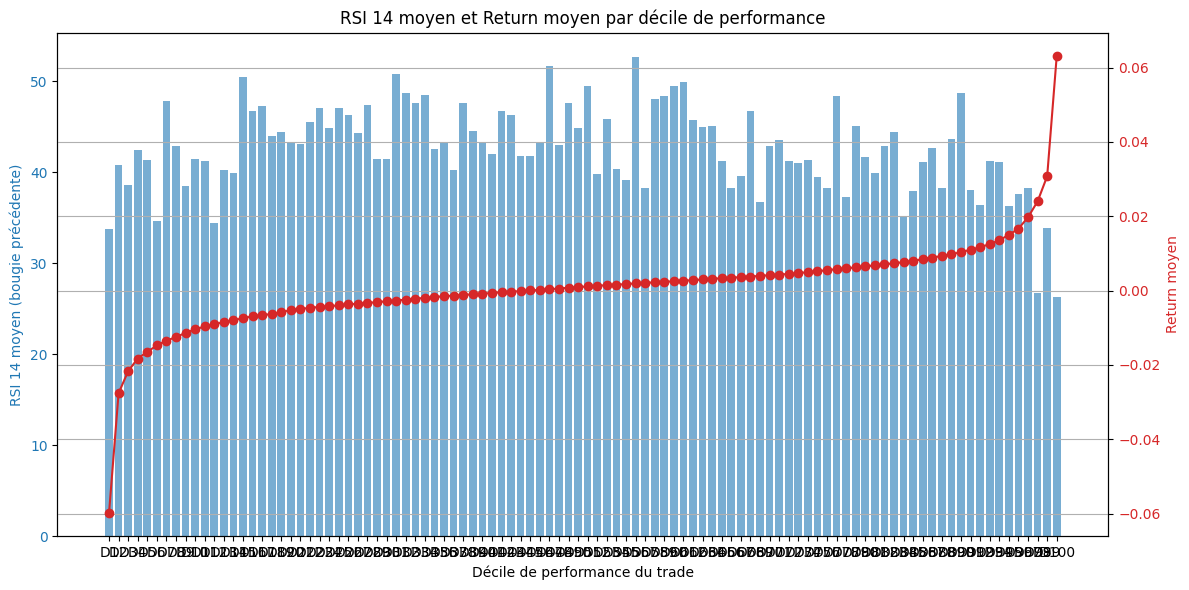

In [117]:
for rsi in rsi_s:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Axe gauche : RSI moyen
    color = "tab:blue"
    ax1.set_xlabel("Décile de performance du trade")
    ax1.set_ylabel(f"RSI {rsi} moyen (bougie précédente)", color=color)
    ax1.bar(rsi_decile[rsi].index, rsi_decile[rsi].values, color=color, alpha=0.6, label=f"RSI {rsi} moyen")
    ax1.tick_params(axis="y", labelcolor=color)

    # Axe droit : Return moyen
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("Return moyen", color=color)
    ax2.plot(return_decile[rsi].index, return_decile[rsi].values, color=color, marker='o', label="Return moyen")
    ax2.tick_params(axis="y", labelcolor=color)

    # Titre et mise en page
    plt.title(f"RSI {rsi} moyen et Return moyen par décile de performance")
    fig.tight_layout()
    plt.grid(True)
    plt.show()